# Hypothesis-driven and discovery-driven analysis with CEBRA

In this notebook, we show how to:

- use CEBRA-Time and CEBRA-Behavior and CEBRA-Hybrid in an hypothesis-driven or discovery-driven analysis.

- use CEBRA-Behavior more specifically in an hypothesis-driven analysis, by testing different hypothesis on positon and direction encoding.

It is mostly based on what we present in [Figure 2](https://cebra.ai/docs/cebra-figures/figures/Figure2.html) in Schneider, Lee, Mathis.

**Install note**
- Be sure you have cebra, and the demo dependencies, installed to use this notebook:

In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
!pip install --pre 'cebra[datasets,demos]'

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [3]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

## Load the data

- The data will be automatically downloaded into a `/data` folder.

In [1]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

NameError: name 'cebra' is not defined

## CEBRA workflow: Discovery-driven and Hypothesis-driven analysis.

- We will compare CEBRA-Time (discovery-driven), CEBRA-Behavior and CEBRA-Hybrid models (hypothesis-driven) as in the recommended [CEBRA workflow](https://cebra.ai/docs/usage.html#the-cebra-workflow).

- We use an output dimension set to 3; in the paper we used 3-64 on the hippocampus data (and found a consistent topology across these dimensions).

**------------------- BEGINNING OF TRAINING SECTION -------------------**

### Train the models

*[You can skip this section if you already have the models saved]*

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

In [4]:
max_iterations = 5000 #default is 5000.

#### CEBRA-Time: Train a model that uses time without the behavior information.
- We can use CEBRA -Time mode by setting conditional = 'time'

In [5]:
cebra_time_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.12,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [9]:
hippocampus_pos.neural.size()

torch.Size([10178, 120])

In [10]:

hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')


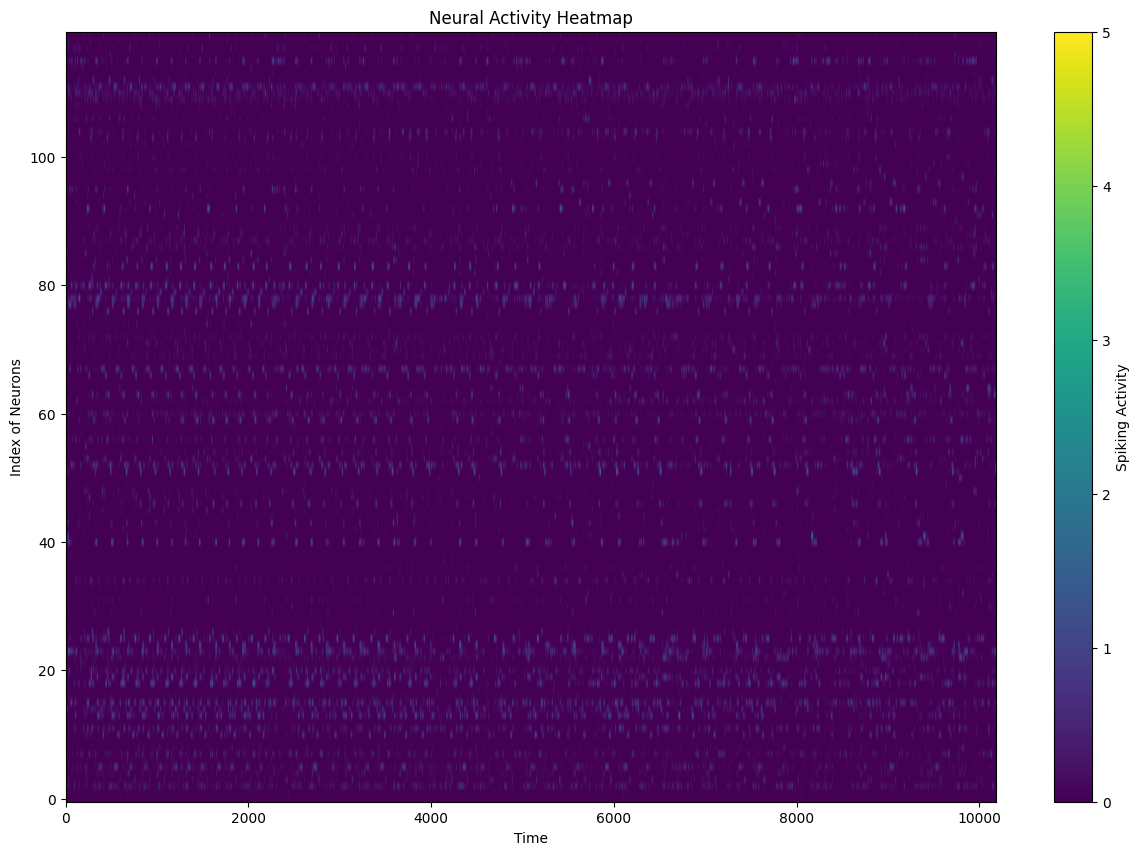

In [11]:
plt.figure(figsize=(15, 10))
plt.imshow(hippocampus_pos.neural.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Spiking Activity')
plt.xlabel('Time')
plt.ylabel('Index of Neurons')
plt.title('Neural Activity Heatmap')
plt.show()

In [12]:
import torch
import numpy as np

# create a mask of size 10178 x 120, where each row represents a neuron and each column represents a time step.
mask = torch.zeros(10178, 120)
block_size = 500
num_blocks = int(10178 / block_size)
for i in range(num_blocks):
  start_index = i * block_size
  end_index = (i + 1) * block_size
  neuron_indices = np.random.choice(120, 30, replace=False)
  mask[start_index:end_index, neuron_indices] = -1
# apply the mask to the neural data
hippocampus_pos_neural_masked = hippocampus_pos.neural.clone()
hippocampus_pos_neural_masked[mask == -1] = -1


def apply_random_noise(data, block_size=500, fill_fraction=0.7):
    mask = torch.ones(data.shape)
    noise_data = data.clone()
    num_blocks = data.shape[0] // block_size
    for i in range(num_blocks):
        start_index = i * block_size
        end_index = (i + 1) * block_size
        neuron_indices = np.random.choice(data.shape[1], int(data.shape[1] * (1 - fill_fraction)), replace=False)
        # Generate random noise for each selected neuron index
        noise_values = torch.rand(len(neuron_indices))   # Random noise between 0 and 5
        for idx, neuron_index in enumerate(neuron_indices):
            noise_data[start_index:end_index, neuron_index] = noise_values[idx]
            mask[start_index:end_index, neuron_index] = 0
    return noise_data, mask

# Example usage
data_shape = hippocampus_pos.neural.shape
noisy_data, mask = apply_random_noise(hippocampus_pos.neural, block_size=500, fill_fraction=0.7)

hippocampus_pos_neural_masked = noisy_data

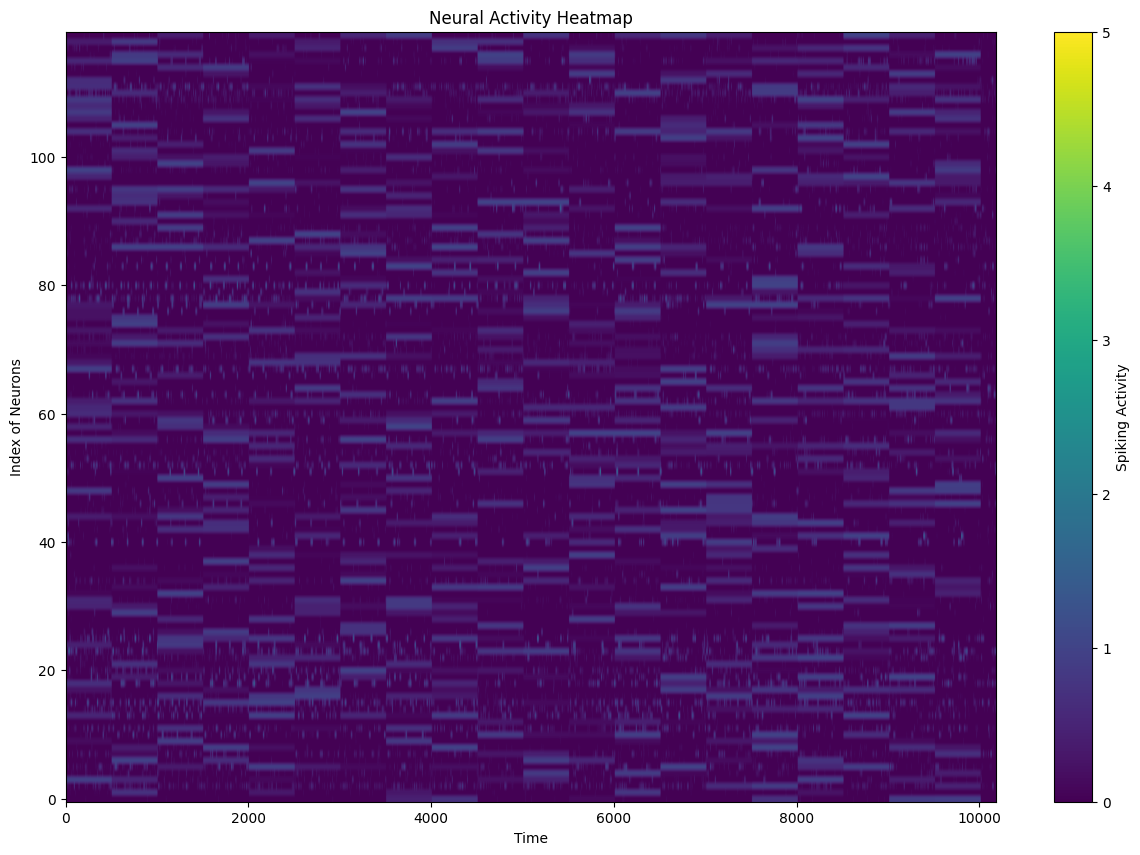

In [13]:
plt.figure(figsize=(15, 10))
plt.imshow(hippocampus_pos_neural_masked.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Spiking Activity')
plt.xlabel('Time')
plt.ylabel('Index of Neurons')
plt.title('Neural Activity Heatmap')
plt.show()

We train the model with neural data only.

In [17]:

def augment_data(neural_data, continuous_index, num_augmentations=5, fill_fraction=0.7, noise_scale=5):
    """
    Augment the dataset by applying random noise.
    """
    augmented_neurals = [neural_data]
    augmented_indices = [continuous_index]

    for _ in range(num_augmentations - 1):  # Minus 1 because we include the original dataset
        mask = torch.rand(neural_data.shape) < fill_fraction
        noise = torch.rand(neural_data.shape) * noise_scale
        augmented_neural = neural_data.clone()
        augmented_neural[~mask] = noise[~mask]  # Apply noise where mask is False

        augmented_neurals.append(augmented_neural)
        augmented_indices.append(continuous_index)  # Repeat indices for each augmented set

    # Concatenate all the data along the first axis
    augmented_neurals = torch.cat(augmented_neurals, dim=0)
    augmented_indices = torch.cat(augmented_indices, dim=0)

    return augmented_neurals, augmented_indices

# Load and prepare original data
original_neural = torch.tensor(cebra.datasets.init('rat-hippocampus-single-achilles').neural, dtype=torch.float32)
original_index = torch.tensor(cebra.datasets.init('rat-hippocampus-single-achilles').continuous_index.numpy(), dtype=torch.float32)

# Generate augmented data
augmented_neural, augmented_index = augment_data(original_neural, original_index)

/tmp/ipykernel_48094/2138844127.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  original_neural = torch.tensor(cebra.datasets.init('rat-hippocampus-single-achilles').neural, dtype=torch.float32)


In [22]:
original_neural.shape

torch.Size([10178, 120])

In [25]:
def augment_data_with_block_masking(neural_data, continuous_index, num_augmentations=5, block_size=100, noise_scale=5):
    augmented_neurals = [neural_data.clone()]
    augmented_indices = [continuous_index.clone()]

    total_blocks = neural_data.shape[0] // block_size

    for _ in range(num_augmentations - 1):
        augmented_neural = neural_data.clone()
        for block in range(total_blocks):
            start_idx = block * block_size
            end_idx = start_idx + block_size
            if end_idx > neural_data.shape[0]:
                end_idx = neural_data.shape[0]
            # Generate mask for randomly selected neurons
            neurons_to_mask = torch.randperm(neural_data.shape[1])[:neural_data.shape[1] // 2]  # Mask about half of the neurons
            # Create noise for the entire block
            noise = torch.rand(end_idx - start_idx, neural_data.shape[1]) * noise_scale
            # Apply noise only to masked neurons
            augmented_neural[start_idx:end_idx, neurons_to_mask] = noise[:, neurons_to_mask]

        augmented_neurals.append(augmented_neural)
        augmented_indices.append(continuous_index)

    augmented_neurals = torch.cat(augmented_neurals, dim=0)
    augmented_indices = torch.cat(augmented_indices, dim=0)

    return augmented_neurals, augmented_indices

# Usage example:
# Load data directly as a tensor if possible or convert properly
# Assuming that the data fetched is already a tensor
original_neural = cebra.datasets.init('rat-hippocampus-single-achilles').neural
if not isinstance(original_neural, torch.Tensor):
    original_neural = torch.from_numpy(original_neural.astype(np.float32))

original_index = cebra.datasets.init('rat-hippocampus-single-achilles').continuous_index
if not isinstance(original_index, torch.Tensor):
    original_index = torch.from_numpy(original_index.astype(np.float32))
    
augmented_neural, augmented_index = augment_data_with_block_masking(original_neural, original_index)

In [12]:
cebra_time_model.fit(hippocampus_pos.neural)
cebra_time_model.save("cebra_time_model.pt")

pos: -0.8489 neg:  6.3683 total:  5.5194 temperature:  1.1200: 100%|██████████| 5000/5000 [00:25<00:00, 199.75it/s]


In [20]:
augmented_neural.shape

torch.Size([50890, 120])

In [16]:
cebra_time_model.fit(augmented_neural)
cebra_time_model.save("cebra_time_model_augmented.pt")

pos: -0.8896 neg:  6.7550 total:  5.8654 temperature:  1.1200: 100%|██████████| 5000/5000 [00:25<00:00, 199.30it/s]


#### CEBRA-Behavior: Train a model with 3D output that uses positional information (position + direction).
- Setting conditional = 'time_delta' means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.

In [26]:
cebra_behavior_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

We train the model with neural data and the behavior variable including position and direction.

In [27]:
cebra_behavior_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_behavior_model.save("cebra_behavior_model.pt")

pos: -0.9041 neg:  6.4132 total:  5.5091 temperature:  1.0000: 100%|██████████| 5000/5000 [00:24<00:00, 205.16it/s]


In [34]:
cebra_behavior_model.fit(augmented_neural, augmented_index)
cebra_behavior_model.save("cebra_behavior_model_augmented.pt")

pos: -0.7917 neg:  6.4580 total:  5.6663 temperature:  1.0000: 100%|██████████| 5000/5000 [00:24<00:00, 204.30it/s]


#### CEBRA-Hybrid: Train a model that uses both time and positional information.

In [30]:
cebra_hybrid_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

In [18]:
cebra_hybrid_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_hybrid_model.save("cebra_hybrid_model.pt")

behavior_pos: -0.8721 behavior_neg:  6.4151 behavior_total:  5.5430 time_pos: -0.9188 time_neg:  6.4151 time_total:  5.4964: 100%|██████████| 5000/5000 [00:39<00:00, 125.78it/s]


In [35]:
cebra_hybrid_model.fit(augmented_neural, augmented_index)
cebra_hybrid_model.save("cebra_hybrid_model_augmented.pt")

behavior_pos: -0.7351 behavior_neg:  6.4190 behavior_total:  5.6839 time_pos: -0.8838 time_neg:  6.4190 time_total:  5.5352: 100%|██████████| 5000/5000 [00:39<00:00, 126.02it/s]


#### CEBRA-Shuffled Behavior: Train a control model with shuffled neural data.
- The model specification is the same as the CEBRA-Behavior above.

In [32]:
cebra_behavior_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

- Now we train the model with shuffled behavior variable.

In [21]:
# Shuffle the behavior variable and use it for training
hippocampus_shuffled_posdir = np.random.permutation(hippocampus_pos.continuous_index.numpy())

cebra_behavior_shuffled_model.fit(hippocampus_pos.neural, hippocampus_shuffled_posdir)
cebra_behavior_shuffled_model.save("cebra_behavior_shuffled_model.pt")

pos: -0.6392 neg:  6.7976 total:  6.1584 temperature:  1.0000: 100%|██████████| 5000/5000 [00:24<00:00, 202.89it/s]


**------------------- END OF TRAINING SECTION -------------------**

### Load the models and get the corresponding embeddings

In [36]:
# CEBRA-Time
cebra_time_model = cebra.CEBRA.load("cebra_time_model.pt")
cebra_time = cebra_time_model.transform(hippocampus_pos.neural)

# CEBRA-Behavior
cebra_behavior_model = cebra.CEBRA.load("cebra_behavior_model.pt")
cebra_behavior = cebra_behavior_model.transform(hippocampus_pos.neural)

# CEBRA-Hybrid
cebra_hybrid_model = cebra.CEBRA.load("cebra_hybrid_model.pt")
cebra_hybrid = cebra_hybrid_model.transform(hippocampus_pos.neural)

# CEBRA-Behavior with shuffled labels
cebra_behavior_shuffled_model = cebra.CEBRA.load("cebra_behavior_shuffled_model.pt")
cebra_behavior_shuffled = cebra_behavior_shuffled_model.transform(hippocampus_pos.neural)

# CEBRA-Behavior-masked
#cebra_behavior_model_masked = cebra.CEBRA.load("cebra_behavior_model_masked.pt")
#cebra_behavior_masked = cebra_behavior_model_masked.transform(hippocampus_pos.neural)

# CEBRA-Hybrid-masked
#cebra_hybrid_model_masked = cebra.CEBRA.load("cebra_hybrid_model_masked.pt")
#cebra_hybrid_masked = cebra_hybrid_model_masked.transform(hippocampus_pos.neural)

# CEBRA-Behavior-augmented
cebra_behavior_model_masked = cebra.CEBRA.load("cebra_behavior_model_augmented.pt")
cebra_behavior_masked = cebra_behavior_model_masked.transform(hippocampus_pos.neural)

# CEBRA-Hybrid-augmented
cebra_hybrid_model_masked = cebra.CEBRA.load("cebra_hybrid_model_augmented.pt")
cebra_hybrid_masked = cebra_hybrid_model_masked.transform(hippocampus_pos.neural)


### Visualize the embeddings from CEBRA-Behavior, CEBRA-Time and CEBRA-Hybrid

In [37]:
right = hippocampus_pos.continuous_index[:,1] == 1
left = hippocampus_pos.continuous_index[:,2] == 1

**Note to Google Colaboratory users:** replace the first line of the next cell (``%matplotlib notebook``) with ``%matplotlib inline``.

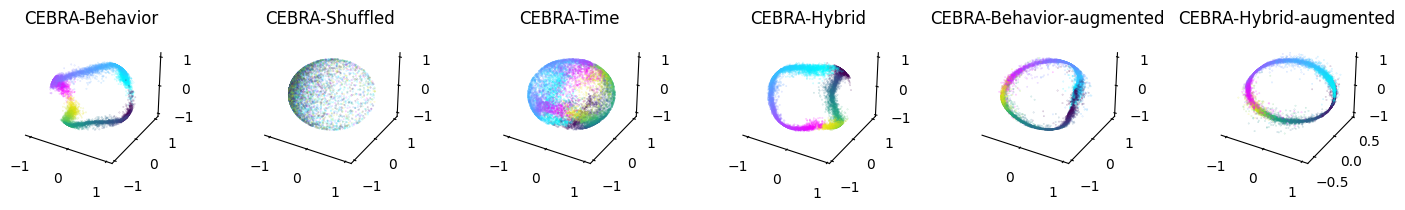

In [38]:
%matplotlib inline

fig = plt.figure(figsize=(18,2))

ax1 = plt.subplot(161, projection='3d')
ax2 = plt.subplot(162, projection='3d')
ax3 = plt.subplot(163, projection='3d')
ax4 = plt.subplot(164, projection='3d')
ax5 = plt.subplot(165, projection='3d')
ax6 = plt.subplot(166, projection='3d')

for dir, cmap in zip([right, left], ["cool", "viridis"]):
    ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_behavior[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Behavior', cmap=cmap)
    ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_behavior_shuffled[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Shuffled', cmap=cmap)
    ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_time[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Time', cmap=cmap)
    ax4=cebra.plot_embedding(ax=ax4, embedding=cebra_hybrid[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Hybrid', cmap=cmap)
    ax5=cebra.plot_embedding(ax=ax5, embedding=cebra_behavior_masked[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Behavior-augmented', cmap=cmap)
    ax6=cebra.plot_embedding(ax=ax6, embedding=cebra_hybrid_masked[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Hybrid-augmented', cmap=cmap)

plt.show()

In [39]:
plt.show()

## Hypothesis testing: compare models with different hypothesis on position encoding of hippocampus

- We will compare CEBRA-Behavior models trained with only position, only direction, both and the control models with shuffled behavior variables.

- Here, we use the set model dimension; in the paper we used 3-64 on the hippocampus data (and found a consistent topology across these dimensions).

In [40]:
def split_data(data, test_ratio):

    split_idx = int(len(data)* (1-test_ratio))
    neural_train = data.neural[:split_idx]
    neural_test = data.neural[split_idx:]
    label_train = data.continuous_index[:split_idx]
    label_test = data.continuous_index[split_idx:]

    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

**------------------- BEGINNING OF TRAINING SECTION -------------------**

### Train the models

*[This can be skipped if you already saved the models].*

#### Train CEBRA-Behavior with position, direction variables and both.

In [27]:
cebra_posdir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [ ]:
# Train CEBRA-Behavior models with both position and direction variables.
cebra_posdir_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir_model.save("cebra_posdir_model.pt")

# Train CEBRA-Behavior models with position only.
cebra_pos_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy()[:,0])
cebra_pos_model.save("cebra_pos_model.pt")

# Train CEBRA-Behavior models with direction only.
cebra_dir_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy()[:,1])
cebra_dir_model.save("cebra_dir_model.pt")

pos: -0.8908 neg:  6.4167 total:  5.5259 temperature:  1.0000: 100%|██████████| 5000/5000 [00:24<00:00, 204.60it/s]
pos: -0.8079 neg:  6.4914 total:  5.6835 temperature:  1.0000:   4%|▍         | 189/5000 [00:00<00:23, 205.42it/s]

In [ ]:
#a session but all for mask
cebra_posdir_model.fit(hippocampus_pos_neural_masked, hippocampus_pos.continuous_index.numpy())
cebra_posdir_model.save("cebra_posdir_model_masked.pt")

cebra_pos_model.fit(hippocampus_pos_neural_masked, hippocampus_pos.continuous_index.numpy()[:,0])
cebra_pos_model.save("cebra_pos_model_masked.pt")

cebra_dir_model.fit(hippocampus_pos_neural_masked, hippocampus_pos.continuous_index.numpy()[:,1])
cebra_dir_model.save("cebra_dir_model_masked.pt")


#### Train control models with shuffled behavior variables.

In [ ]:
cebra_posdir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [ ]:
# Generate shuffled behavior labels for train set.
shuffled_posdir = np.random.permutation(hippocampus_pos.continuous_index.numpy())
shuffled_pos = np.random.permutation(hippocampus_pos.continuous_index.numpy()[:,0])
shuffled_dir = np.random.permutation(hippocampus_pos.continuous_index.numpy()[:,1])


# Train the models with shuffled behavior variables
cebra_posdir_shuffled_model.fit(hippocampus_pos.neural, shuffled_posdir)
cebra_posdir_shuffled_model.save("cebra_posdir_shuffled_model.pt")

cebra_pos_shuffled_model.fit(hippocampus_pos.neural, shuffled_pos)
cebra_pos_shuffled_model.save("cebra_pos_shuffled_model.pt")

cebra_dir_shuffled_model.fit(hippocampus_pos.neural, shuffled_dir)
cebra_dir_shuffled_model.save("cebra_dir_shuffled_model.pt")

**------------------- END OF TRAINING SECTION -------------------**

### Load the model and get the corresponding embeddings

In [ ]:
# We get train set embedding and test set embedding.

cebra_posdir_model = cebra.CEBRA.load("cebra_posdir_model.pt")
cebra_posdir = cebra_posdir_model.transform(hippocampus_pos.neural)

cebra_pos_model = cebra.CEBRA.load("cebra_pos_model.pt")
cebra_pos = cebra_pos_model.transform(hippocampus_pos.neural)

cebra_dir_model = cebra.CEBRA.load("cebra_dir_model.pt")
cebra_dir = cebra_dir_model.transform(hippocampus_pos.neural)

cebra_posdir_masked_model = cebra.CEBRA.load("cebra_posdir_model_masked.pt")
cebra_posdir_masked = cebra_posdir_masked_model.transform(hippocampus_pos.neural)

cebra_pos_masked_model = cebra.CEBRA.load("cebra_pos_model_masked.pt")
cebra_pos_masked = cebra_pos_masked_model.transform(hippocampus_pos.neural)

cebra_dir_masked_model = cebra.CEBRA.load("cebra_dir_model_masked.pt")
cebra_dir_masked = cebra_dir_masked_model.transform(hippocampus_pos.neural)

In [ ]:
# ... and similarily for models with shuffled variables

cebra_posdir_shuffled_model = cebra.CEBRA.load("cebra_posdir_shuffled_model.pt")
cebra_posdir_shuffled_train = cebra_posdir_shuffled_model.transform(hippocampus_pos.neural)

cebra_pos_shuffled_model = cebra.CEBRA.load("cebra_pos_shuffled_model.pt")
cebra_pos_shuffled_train = cebra_pos_shuffled_model.transform(hippocampus_pos.neural)

cebra_dir_shuffled_model = cebra.CEBRA.load("cebra_dir_shuffled_model.pt")
cebra_dir_shuffled_train = cebra_dir_shuffled_model.transform(hippocampus_pos.neural)

### Visualize embeddings from different hypothesis

In [ ]:
fig=plt.figure(figsize=(9,9))

ax1=plt.subplot(331, projection = '3d')
ax2=plt.subplot(332, projection = '3d')
ax3=plt.subplot(333, projection = '3d')
ax4=plt.subplot(334, projection = '3d')
ax5=plt.subplot(335, projection = '3d')
ax6=plt.subplot(336, projection = '3d')
ax7=plt.subplot(337, projection = '3d')
ax8=plt.subplot(338, projection = '3d')
ax9=plt.subplot(339, projection = '3d')

ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_pos, embedding_labels="grey", title='position only')
ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_dir, embedding_labels="grey", title='direction only')
ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_posdir, embedding_labels="grey", title='position+direction')
ax4=cebra.plot_embedding(ax=ax4, embedding=cebra_pos_shuffled_train, embedding_labels="grey", title='position, shuffled')
ax5=cebra.plot_embedding(ax=ax5, embedding=cebra_dir_shuffled_train, embedding_labels="grey", title='direction, shuffled')
ax6=cebra.plot_embedding(ax=ax6, embedding=cebra_posdir_shuffled_train, embedding_labels="grey", title='pos+dir, shuffled')
ax7=cebra.plot_embedding(ax=ax7, embedding=cebra_pos_masked, embedding_labels="grey", title='position, masked')
ax8=cebra.plot_embedding(ax=ax8, embedding=cebra_dir_masked, embedding_labels="grey", title='direction, masked')
ax9=cebra.plot_embedding(ax=ax9, embedding=cebra_posdir_masked, embedding_labels="grey", title='pos+dir, masked')

plt.show()

### Visualize the loss of models trained with different hypothesis

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

ax = cebra.plot_loss(cebra_posdir_model, color='deepskyblue', label='position+direction', ax=ax)
#ax = cebra.plot_loss(cebra_pos_model, color='deepskyblue', alpha=0.3, label='position', ax=ax)
#ax = cebra.plot_loss(cebra_dir_model, color='deepskyblue', alpha=0.9,label='direction', ax=ax)

ax = cebra.plot_loss(cebra_posdir_shuffled_model, color='gray', label='pos+dir, shuffled', ax=ax)
#ax = cebra.plot_loss(cebra_pos_shuffled_model, color='gray', alpha=0.3, label='position, shuffled', ax=ax)
#ax = cebra.plot_loss(cebra_dir_shuffled_model, color='gray', alpha=0.9, label='direction, shuffled', ax=ax)

ax = cebra.plot_loss(cebra_posdir_masked_model, color='orange', label='pos+dir, masked', ax=ax)
#ax = cebra.plot_loss(cebra_pos_masked_model, color='orange', alpha=0.3, label='position, masked', ax=ax)
#ax = cebra.plot_loss(cebra_dir_masked_model, color='orange', alpha=0.9, label='direction, masked', ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False)
plt.show()